In [29]:
import specAugment
import torch
import librosa
import numpy as np
import pandas as pd
from skimage.transform import resize

In [24]:
#!pip3 install ffmpeg-normalize

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [22]:
import zipfile
#zip = ZipFile('rfcx-species-audio-detection.zip')
#zip.extractall()
with zipfile.ZipFile('rfcx-species-audio-detection.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
#audio = '/home/tuk99233/train/003b04435.flac'

In [5]:
#samples, sample_rate =librosa.load(audio, sr = None)

In [10]:
#df = pd.read_csv('train_spectograms.csv')

In [16]:
#samples = to2DArray(df['spec'][0])

In [13]:
#sample_rate = 48000

In [15]:
def to2DArray(x): 
    x=x.replace("[", '')
    x=x.replace("]", '')
    x=x.replace("...", '')
    x=x.replace("\n", '')
    y=np.array(x.split(" "))
    y = y[y != ""]
    y = np.asfarray(y, 'float64')
    y = np.reshape(y,(1, y.size))
    return y

In [27]:
fft = 2048
hop = 512 
# According to research, standard sampling bitrate is 48khz. Seen in discussion of kaggle competition as well. 
sr = 48000
length = 10*sr
# ResNet50 input layer is 224 x 224 x 3, so I'm resizing the image to fit the first input dimension. 
mel_spec_dimensions = (224,224)

In [53]:
def create_mel_spectograms(df):
     df['spec'] = np.nan
     df['spec'] = df['spec'].astype(object)
     df2 = df.copy(deep = True)
     df2['recording_id'] = df2['recording_id'].apply(lambda x: "{}_2".format(x))
     for idx,row in df.iterrows():
        
         rid = row['recording_id']

         wav, sr = librosa.load('train/' + rid + '.flac', sr=None)

         # Slicing and centering spectograms 
         m = np.round((row['t_min'] + row['t_max']) / 2)
         l = m - length / 2
         if l < 0: l = 0
         r = m + length
         if r > len(wav):
             r = len(wav)
             l = r - m

         mspec = librosa.feature.melspectrogram(y=wav[int(l):int(r)], n_fft=fft, hop_length=hop, sr=sr)
         mspec = resize(mspec, mel_spec_dimensions)
         mspec = (mspec - np.min(mspec))/np.max(mspec)
         
         #Make Noisy Versions
         y_noise = mspec.copy()
         noise_amp = 0.005*np.random.uniform()*np.amax(y_noise)
         y_noise = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])
         
         df2.at[idx, 'spec'] = y_noise
         df.at[idx, 'spec'] = mspec
     frames = [df, df2]
     result = pd.concat(frames)   
     return df

In [33]:
wav, sr = librosa.load('train/' + '003bec244' + '.flac', sr=None)

         # Slicing and centering spectograms 
m = np.round((44.5440 + 45.1307) / 2)
l = m - length / 2
if l < 0: l = 0
r = m + length
if r > len(wav):
    r = len(wav)
    l = r - m
mspec = librosa.feature.melspectrogram(y=wav[int(l):int(r)], n_fft=fft, hop_length=hop, sr=sr)
mspec = resize(mspec, mel_spec_dimensions)
mspec = (mspec - np.min(mspec))/np.max(mspec)

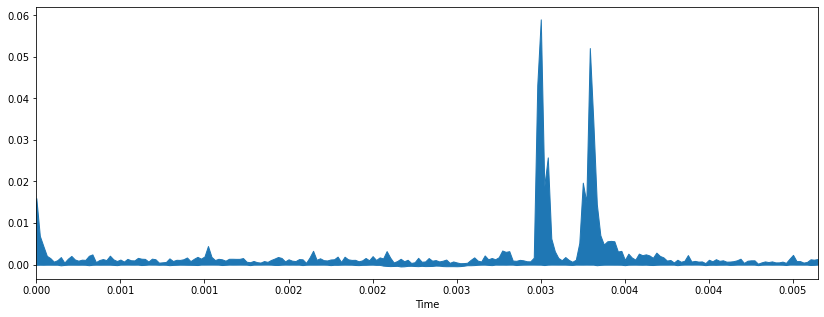

In [37]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(mspec, sr=sr)

In [35]:
y_noise = mspec.copy()
# you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
noise_amp = 0.005*np.random.uniform()*np.amax(y_noise)
y_noise = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])

In [40]:
input_length = len(wav)
streching = wav.copy()
streching = librosa.effects.time_stretch(streching.astype('float'), 1.1)
if len(streching) > input_length:
    streching = streching[:input_length]
else:
    streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")

In [54]:
df = pd.read_csv('train_spectograms.csv')
df = create_mel_spectograms(df)

In [55]:
df.head()

,Unnamed: 0,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,spec
0,0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25,"[[0.015969152, 0.0068952353, 0.004454193, 0.00..."
1,1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40,"[[0.00960646, 0.027989434, 0.066221, 0.0223827..."
2,2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25,"[[0.09593078, 0.24144638, 0.07836443, 0.084347..."
3,3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04,"[[0.10142235, 0.08636865, 0.07434975, 0.119185..."
4,4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70,"[[0.1255407, 0.032630917, 0.01827762, 0.018702..."


In [59]:
df= df.drop(['Unnamed: 0'], axis = 1)

In [60]:
df.to_csv('train_Augmented.csv')

In [17]:
import librosa.display
import matplotlib.pyplot as plt

# x-axis has been converted to time using our sample rate. 
# matplotlib plt.plot(y), would output the same figure, but with sample 
# number on the x-axis instead of seconds
plt.figure(figsize=(14, 5))
librosa.display.waveplot(samples, sr=sample_rate)

ParameterError: Mono data must have shape (samples,). Received shape=(1, 36)

<Figure size 1008x360 with 0 Axes>

/opt/conda/lib/python3.8/site-packages/librosa/display.py:954: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn(


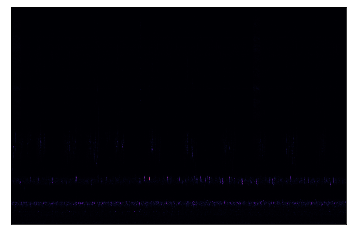

In [7]:
#Short Form Fourier Transformation
sgram = librosa.stft(samples)
librosa.display.specshow(sgram)

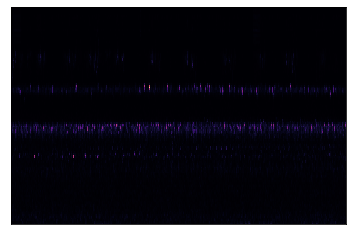

In [9]:
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
librosa.display.specshow(mel_scale_sgram)

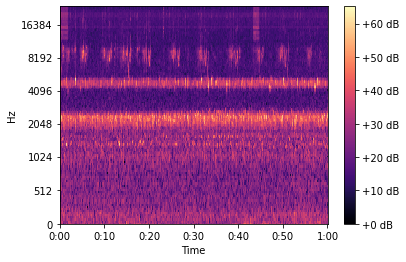

In [10]:
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [12]:
#Change Pitch
#Possibly Normalize it so it is standard between samples

y_pitch = samples.copy()
bins_per_octave = 12
pitch_pm = 2
pitch_change =  pitch_pm * 2*(np.random.uniform())   
print("pitch_change = ",pitch_change)
y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
#Audio(y_pitch, rate=sample_rate)

pitch_change =  1.9793577947680285


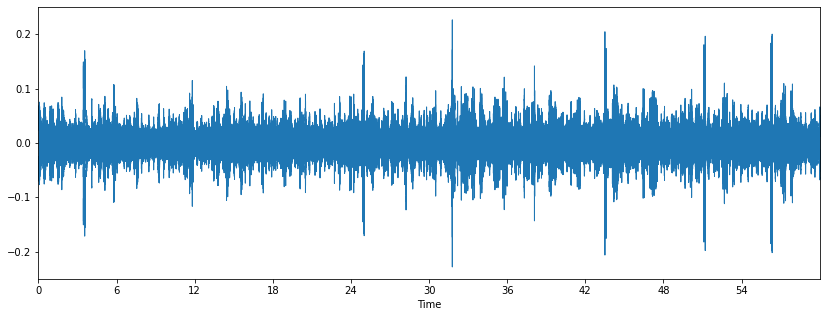

In [13]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y_pitch, sr=sample_rate)

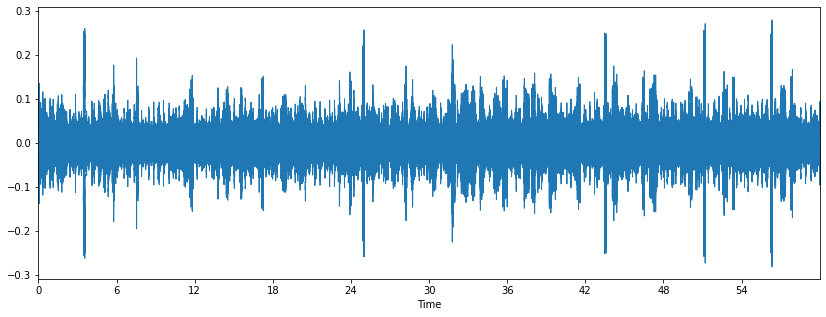

In [17]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y_noise, sr=sample_rate)

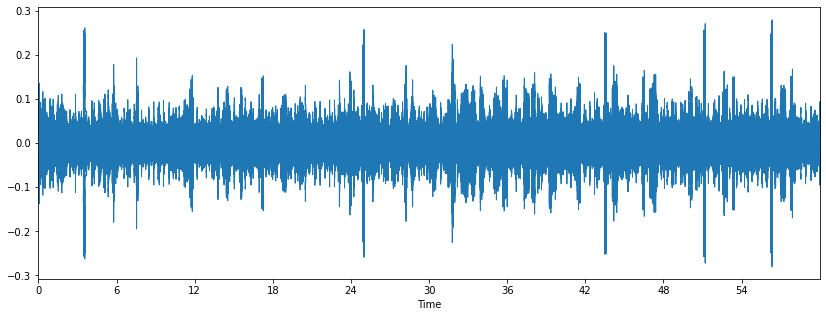

In [23]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(streching, sr=sample_rate)

In [22]:
y_noise = samples.copy()
# you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
noise_amp = 0.005*np.random.uniform()*np.amax(y_noise)
y_noise = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])

In [19]:
input_length = len(samples)
streching = samples.copy()
streching = librosa.effects.time_stretch(streching.astype('float'), 1.1)
if len(streching) > input_length:
    streching = streching[:input_length]
else:
    streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")
#Audio(streching, rate=sample_rate)